# PixelCNN: A Generative Model
PixelCNN is a type of autoregressive generative model developed for modeling images. It captures the dependencies between pixels, allowing it to generate new images pixel by pixel. Unlike traditional generative models, PixelCNN models the conditional distribution of each pixel given the previous ones.


## Autoregressive Models
Autoregressive models aim to predict the next element in a sequence based on prior elements. In the context of images, PixelCNN models the probability distribution of each pixel given all previous pixels in raster order (top to bottom, left to right). This enables generating images from scratch.

The key idea of PixelCNN is to factor the image's joint distribution into a product of conditional distributions:
$$ P(x) = \prod_i P(x_i | x_{1:i-1}) $$

Where each pixel is conditioned on the previous pixels.


## PixelCNN Architecture
PixelCNN uses a stack of convolutional layers where each layer is masked to ensure that the pixel at position (i, j) only depends on previous pixels. The network models the conditional probability of a pixel given its neighbors.

The structure can be visualized as:

![PixelCNN Architecture](https://camo.githubusercontent.com/2f581257c289298057989d11aa1ad507c2af397b2471c592f7b17a5dbecd731e/687474703a2f2f736572676569747572756b696e2e636f6d2f6173736574732f323031372d30322d32322d3138333031305f343739783439345f7363726f742e706e67)  <!-- Add actual image reference here -->


## PixelCNN Architecture
PixelCNN uses a stack of convolutional layers where each layer is masked to ensure that the pixel at position (i, j) only depends on previous pixels. The network models the conditional probability of a pixel given its neighbors.

The structure can be visualized as:

![PixelCNN Architecture](https://camo.githubusercontent.com/2b432c6d87633c75685c3703167c0a6b5a6d6592a7ca95540bf02f6de890052c/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f706978656c2d636e6e2e706e67)  <!-- Add actual image reference here -->


## Masked Convolutions
PixelCNN employs masked convolutions to ensure that future pixels are not used in the computation of the current pixel's distribution. There are two types of masks:

- **Mask A**
- **Mask B**

This technique helps preserve the autoregressive nature of the model.


## Implementation

PyTorch buffers are tensor attributes associated with a PyTorch module or model similar to parameters, but unlike parameters, buffers are not updated during training.



1. Preparing the Data

First, we'll load the MNIST dataset and preprocess it to suit the PixelCNN model's input requirements.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define transformations: Convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders wrap an iterable around the Dataset to enable easy access to the samples.
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


**Transforms:** We convert the images to tensors. PixelCNN expects input images normalized between 0 and 1, which is already handled by transforms.ToTensor().

**Data Loaders:** We create data loaders for training and testing with a specified batch_size.

2. Implementing the PixelCNN Model

**Masked Convolutions**

PixelCNN uses masked convolutions to ensure the model only considers pixels up to the current position. There are two types of masks:

*   Mask A: Used in the first layer to prevent the current pixel from being included in the receptive field.
*   Mask B: Used in subsequent layers, allowing the current pixel but masking future pixels.

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class MaskedConv2d(nn.Conv2d):
    """
    Masked convolution layer for PixelCNN.
    """
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)
        self.device = torch.device('cuda') if torch.cuda.is_available() else None
        # self.register_buffer('mask', torch.ones(out_channels, in_channels, kernel_size, kernel_size).to(self.device))
        self.mask = torch.ones(out_channels, in_channels, kernel_size, kernel_size).to(self.device)
        _, _, height, width = self.mask.size()
        # self.mask.fill_(1)
        center = kernel_size // 2

        # For Mask A, zero out the center pixel
        # Mask A: Prevents the convolution from accessing the current pixel and future pixels. It's used in the first layer.
        for i in range(kernel_size):
            for j in range(kernel_size):
                if i > center or (i == center and j > center):
                    self.mask[:, :, i, j] = 0
        if mask_type == 'A':
            self.mask[:, :, center, center] = 0  # Mask out the center for Mask A
        # Mask B: Allows the convolution to access the current pixel but still prevents access to future pixels. It's used in all subsequent layers.
        elif mask_type == 'B':
            pass  # Mask B allows the center pixel
        else:
            raise ValueError("mask_type must be either 'A' or 'B'")

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)


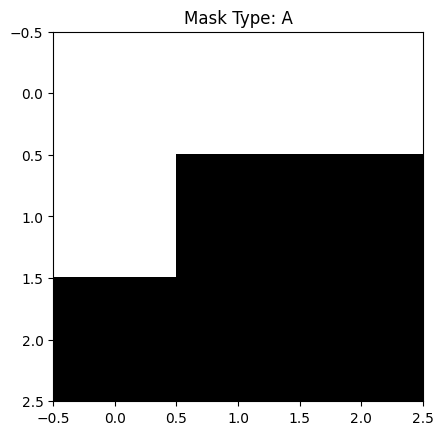

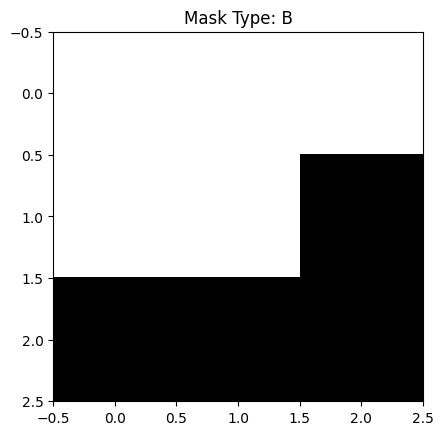

In [ ]:
import matplotlib.pyplot as plt

def visualize_mask(masked_conv):
    mask = masked_conv.mask[0,0].cpu().numpy()
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask Type: {masked_conv.mask_type}")
    plt.show()

# Example
mask_A = MaskedConv2d('A', 1, 1, 3, padding=1)
mask_A.mask_type = 'A'
mask_B = MaskedConv2d('B', 1, 1, 3, padding=1)
mask_B.mask_type = 'B'

visualize_mask(mask_A)
visualize_mask(mask_B)


Building the PixelCNN Model

We'll create a PixelCNN model with the specified architecture:

*   8 Convolutional Layers:
    *   First 6 layers with a kernel size of 7.
    *   Last 2 layers with a kernel size of 1.
*   64 Channels:
    *   Each convolutional layer has 64 output channels.
*   Activation Functions:
    *   ReLU after each convolutional layer.
    *   Sigmoid activation at the final layer to output pixel probabilities.


In [ ]:
class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, kernel_size=7, num_layers=8):
        super(PixelCNN, self).__init__()
        layers = []

        # First layer uses Mask A
        layers.append(MaskedConv2d('A', input_channels, hidden_channels, kernel_size, padding=kernel_size//2))
        layers.append(nn.ReLU())

        # Next 6 layers use Mask B with kernel size 7
        for _ in range(5):
            layers.append(MaskedConv2d('B', hidden_channels, hidden_channels, kernel_size, padding=kernel_size//2))
            layers.append(nn.ReLU())

        # Last 2 layers with kernel size 1
        layers.append(MaskedConv2d('B', hidden_channels, hidden_channels, kernel_size=1, padding=0))
        layers.append(nn.ReLU())
        layers.append(MaskedConv2d('B', hidden_channels, input_channels, kernel_size=1, padding=0))
        layers.append(nn.Sigmoid())  # Since MNIST pixels are between 0 and 1

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)



**MaskedConv2d Layers:** Ensures the autoregressive property by masking future pixels.

**ReLU Activation:** Introduces non-linearity after each convolution.

**Sigmoid Activation:** Outputs pixel probabilities between 0 and 1.

3. Training the Model

We'll define the training loop, set the optimizer, and plot the training and testing loss.



cuda:0


Epoch 1/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 46.04it/s]


Epoch [1/30], Train Loss: 0.1113, Test Loss: 0.0806


Epoch 2/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.49it/s]


Epoch [2/30], Train Loss: 0.0797, Test Loss: 0.0782


Epoch 3/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.76it/s]


Epoch [3/30], Train Loss: 0.0783, Test Loss: 0.0774


Epoch 4/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 48.70it/s]


Epoch [4/30], Train Loss: 0.0777, Test Loss: 0.0771


Epoch 5/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 48.64it/s]


Epoch [5/30], Train Loss: 0.0771, Test Loss: 0.0765


Epoch 6/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.81it/s]


Epoch [6/30], Train Loss: 0.0768, Test Loss: 0.0764


Epoch 7/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.70it/s]


Epoch [7/30], Train Loss: 0.0766, Test Loss: 0.0762


Epoch 8/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 46.42it/s]


Epoch [8/30], Train Loss: 0.0763, Test Loss: 0.0759


Epoch 9/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.32it/s]


Epoch [9/30], Train Loss: 0.0761, Test Loss: 0.0758


Epoch 10/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.95it/s]


Epoch [10/30], Train Loss: 0.0759, Test Loss: 0.0755


Epoch 11/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 46.20it/s]


Epoch [11/30], Train Loss: 0.0757, Test Loss: 0.0757


Epoch 12/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.60it/s]


Epoch [12/30], Train Loss: 0.0756, Test Loss: 0.0753


Epoch 13/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.74it/s]


Epoch [13/30], Train Loss: 0.0755, Test Loss: 0.0754


Epoch 14/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 49.21it/s]


Epoch [14/30], Train Loss: 0.0753, Test Loss: 0.0751


Epoch 15/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 47.32it/s]


Epoch [15/30], Train Loss: 0.0752, Test Loss: 0.0749


Epoch 16/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.77it/s]


Epoch [16/30], Train Loss: 0.0751, Test Loss: 0.0748


Epoch 17/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.43it/s]


Epoch [17/30], Train Loss: 0.0750, Test Loss: 0.0746


Epoch 18/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 45.99it/s]


Epoch [18/30], Train Loss: 0.0749, Test Loss: 0.0751


Epoch 19/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.79it/s]


Epoch [19/30], Train Loss: 0.0748, Test Loss: 0.0747


Epoch 20/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.97it/s]


Epoch [20/30], Train Loss: 0.0747, Test Loss: 0.0746


Epoch 21/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 47.75it/s]


Epoch [21/30], Train Loss: 0.0746, Test Loss: 0.0747


Epoch 22/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 49.78it/s]


Epoch [22/30], Train Loss: 0.0746, Test Loss: 0.0744


Epoch 23/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.96it/s]


Epoch [23/30], Train Loss: 0.0745, Test Loss: 0.0744


Epoch 24/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.82it/s]


Epoch [24/30], Train Loss: 0.0745, Test Loss: 0.0742


Epoch 25/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 47.69it/s]


Epoch [25/30], Train Loss: 0.0744, Test Loss: 0.0743


Epoch 26/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.76it/s]


Epoch [26/30], Train Loss: 0.0744, Test Loss: 0.0742


Epoch 27/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.72it/s]


Epoch [27/30], Train Loss: 0.0743, Test Loss: 0.0744


Epoch 28/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 45.61it/s]


Epoch [28/30], Train Loss: 0.0742, Test Loss: 0.0742


Epoch 29/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.33it/s]


Epoch [29/30], Train Loss: 0.0742, Test Loss: 0.0742


Epoch 30/30 - Testing: 100%|██████████| 157/157 [00:03<00:00, 50.66it/s]


Epoch [30/30], Train Loss: 0.0742, Test Loss: 0.0741


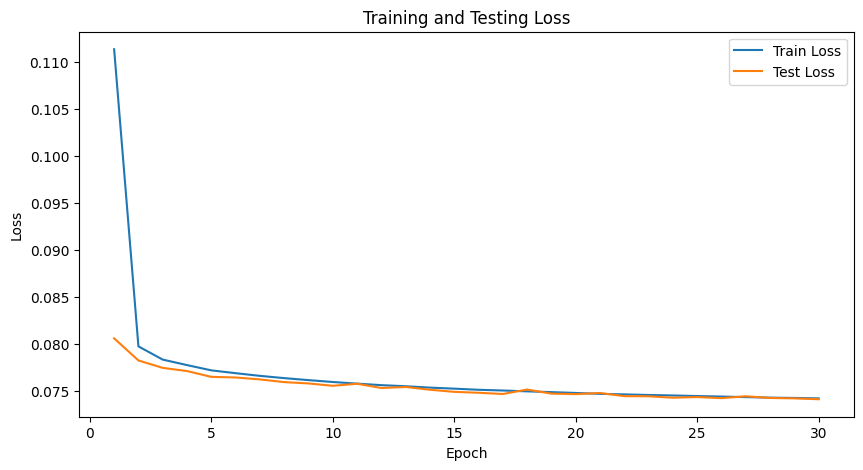

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

# Initialize model, loss function, and optimizer
model = PixelCNN().to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy for pixel-wise binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 30

# Lists to store loss
train_losses = []
test_losses = []

print(next(model.parameters()).device)  # Should print 'cuda:0' if using GPU


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        images = images.to(device)  # Move images to GPU if available
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Testing'):
            images = images.to(device)  # Move images to GPU if available
            outputs = model(images)
            loss = criterion(outputs, images)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Plotting the loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()


In [ ]:
import os

save_path = "Models" #path where the models are to be saved
#Saving the model
if not os.path.exists(save_path):
	os.makedirs(save_path)
print("Saving Checkpoint!")
torch.save(model.state_dict(), save_path+'/Model_Checkpoint_'+str(num_epochs)+'_Epochs'+'.pt')
print('Checkpoint Saved')

Saving Checkpoint!
Checkpoint Saved


**Loss Function:** We use Binary Cross Entropy (nn.BCELoss) since MNIST pixels are binary (0 or 1).

**Optimizer:** Adam optimizer with a learning rate of 0.001.

**Training Loop:** For each epoch, we train the model and evaluate it on the test set, recording the loss.

**Plotting:** Visualizes the training and testing loss over epochs to monitor performance.

4. Generating Samples

After training, we'll generate new samples by sequentially predicting each pixel based on the previously generated pixels.

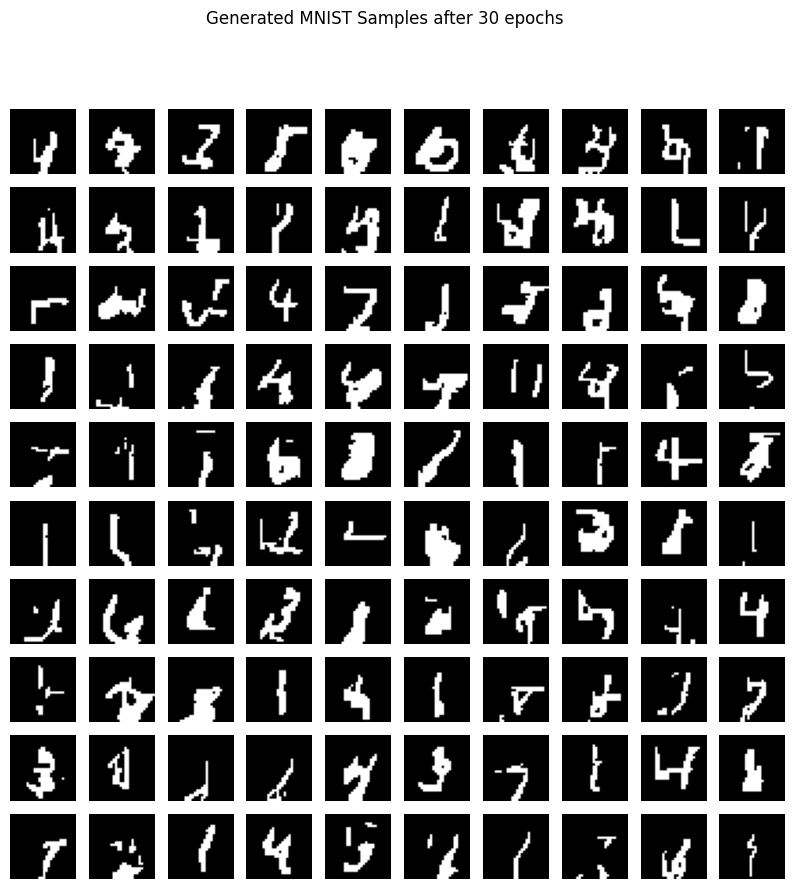

In [ ]:
import matplotlib.pyplot as plt

def generate_samples(model, num_samples=100):
    model.eval()
    device = torch.device('cuda') if torch.cuda.is_available() else None
    samples = torch.zeros(num_samples, 1, 28, 28).to(device)  # MNIST images are 28x28
    with torch.no_grad():
        for i in range(28):
            for j in range(28):
                outputs = model(samples)
                prob = outputs[:, :, i, j]
                samples[:, :, i, j] = torch.bernoulli(prob)
    return samples

# Generate 100 samples
generated_samples = generate_samples(model, num_samples=100)

# Plot some samples
fig, axes = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(generated_samples[i*10 + j, 0].cpu(), cmap='gray')
        axes[i,j].axis('off')
plt.suptitle('Generated MNIST Samples after '+str(num_epochs)+' epochs')
plt.show()


*   Sample Generation:
    *   We initialize a tensor of zeros with the shape (num_samples, 1, 28, 28).
    *   For each pixel position (i, j), we pass the current state of the image through the model to get the probability of the pixel being 1.
    *   We sample from this probability using torch.bernoulli to decide if the pixel is 1 or 0.
*   Visualization:
    *   Displays a grid of generated samples to visualize the model's performance.